In [ ]:
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
import copy
from torch import autograd
import itertools
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

I have adopted the code from https://github.com/TinfoilHat0/Learning-to-Reweight-Examples-for-Robust-Deep-Learning-with-PyTorch-Higher and modified for different architectures on various benchmark datasets.

In [ ]:
!pip install higher

In [ ]:
import higher

In [ ]:
class LeNet5(torch.nn.Module):          
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        self.fc1 = torch.nn.Linear(16*6*6, 120)   
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.max_pool_1(x) 
        x = F.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        return x

In [ ]:
# l = LeNet5()
# print(l)

In [ ]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=3):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet18(pretrained=True)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 1)

  def forward(self, x):
    return self.model(x)

In [ ]:
def get_loss_n_accuracy(model, criterion, data_loader, args, num_classes=2):
    """ Returns the loss and total accuracy, per class accuracy on the supplied data loader """
    
    criterion.reduction = 'mean'
    model.eval()                                     
    total_loss, correctly_labeled_samples = 0, 0
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    # forward-pass to get loss and predictions of the current batch
    for _, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                labels.to(device=args['device'], non_blocking=True)
        #labels =labels.unsqueeze(1)                                  
        # compute the total loss over minibatch
        outputs = model(inputs)
        avg_minibatch_loss = criterion(outputs, labels.type_as(outputs))
        total_loss += avg_minibatch_loss.item()*outputs.shape[0]
                        
        # get num of correctly predicted inputs in the current batch
        pred_labels = (torch.sigmoid(outputs) > 0.5).int()
        correctly_labeled_samples += torch.sum(torch.eq(pred_labels.view(-1), labels)).item()
        # fill confusion_matrix
        for t, p in zip(labels.view(-1), pred_labels.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                                
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correctly_labeled_samples / len(data_loader.dataset)
    per_class_accuracy = confusion_matrix.diag() / confusion_matrix.sum(1)
    return avg_loss, (accuracy, per_class_accuracy)

In [ ]:
def get_imbalanced_datasets(train_dataset, test_dataset, imbalance=0.995, train_size=5000, meta_size=10):
    # returns an imbalanced mnist dataset of 9 and 4s where imbalance favors 9s
    
    test_dataset.targets = np.asarray(test_dataset.targets)
    train_dataset.targets =np.asarray(train_dataset.targets)
    
    # a balanced test dataset
    print(np.count_nonzero(torch.from_numpy(train_dataset.targets) == 0))
    print(np.count_nonzero(torch.from_numpy(train_dataset.targets) == 6))
    test_9_idxs = torch.from_numpy(test_dataset.targets) == 0
    print(test_dataset.targets)
    test_4_idxs = torch.from_numpy(test_dataset.targets) == 6
    test_9_data = test_dataset.data[test_9_idxs][:982]
    test_4_data = test_dataset.data[test_4_idxs][:982] # num of 4 samples 
    test_data = np.concatenate((test_9_data, test_4_data))
    test_targets = np.concatenate((torch.ones(len(test_9_data))*1, torch.ones(len(test_4_data))*0 ))
    test_dataset.data = test_data
    test_dataset.targets = test_targets

    # imbalanced training dataset
    n_9s = int(train_size * imbalance)
    n_4s = train_size - n_9s
    train_9_idxs = torch.from_numpy(train_dataset.targets) == 0
    train_4_idxs = torch.from_numpy(train_dataset.targets) == 6 
    train_9_data = train_dataset.data[train_9_idxs][:n_9s]
    train_4_data = train_dataset.data[train_4_idxs][:n_4s]
    train_data = np.concatenate((train_9_data, train_4_data))
    train_targets = np.concatenate((torch.ones(len(train_9_data))*1, torch.ones(len(train_4_data))*0 ))
    train_dataset.data = train_data
    train_dataset.targets = train_targets
    
    # a balanced meta dataset for weighting samples (which is subset of training dataset)
    # note that we have relabed 9s as 1 and 4s as 0
    meta_dataset = copy.deepcopy(train_dataset)
    meta_dataset.targets =np.asarray(meta_dataset.targets)
    meta_9_idxs = torch.from_numpy(meta_dataset.targets) == 1
    meta_4_idxs = torch.from_numpy(meta_dataset.targets) == 0
    meta_9_data = meta_dataset.data[meta_9_idxs][:(meta_size // 2)]
    meta_4_data = meta_dataset.data[meta_4_idxs][:(meta_size // 2)]
    meta_data = np.concatenate((meta_9_data, meta_4_data))
    meta_dataset.data = meta_data
    meta_targets = np.concatenate( (torch.ones(len(meta_9_data))*1, torch.ones(len(meta_4_data))*0 ) )
    meta_dataset.targets = meta_targets
    
    return train_dataset, meta_dataset, test_dataset   

In [ ]:
args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
train_dataset, meta_dataset, test_dataset = get_imbalanced_datasets(train_dataset, test_dataset)

Files already downloaded and verified
Files already downloaded and verified
5000
5000
[3 8 8 ... 5 1 7]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=args['bs'], shuffle=True, num_workers=0, pin_memory=True)
test_loader =  DataLoader(test_dataset, batch_size=args['bs'], shuffle=False, num_workers=0, pin_memory=True)
meta_loader = DataLoader(meta_dataset, batch_size=args['bs'], shuffle=True, pin_memory=True)
meta_loader = itertools.cycle(meta_loader)

In [ ]:
from torchvision import transforms, utils, models
model = LeNet5().to(args['device'])
opt = optim.SGD(model.parameters(), lr=args['lr'])
criterion = nn.BCEWithLogitsLoss().to(args['device'])

In [ ]:
start_time, end_time = torch.cuda.Event(enable_timing=True),\
                        torch.cuda.Event(enable_timing=True)
start_time.record()

In [ ]:
for ep in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    train_loss, train_acc = 0, 0
    for _, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                            labels.to(device=args['device'], non_blocking=True)
        #labels =labels.unsqueeze(1)  
        opt.zero_grad()
        outputs = model(inputs)
        minibatch_loss = criterion(outputs, labels.type_as(outputs))
        minibatch_loss.backward()
        opt.step()

        # keep track of epoch loss/accuracy
        train_loss += minibatch_loss.item()*outputs.shape[0]
        pred_labels = (torch.sigmoid(outputs) > 0.5).int()
        train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
        
    # inference after epoch
    with torch.no_grad():
        train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
        test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)                                  
        # log/print data
        # writer.add_scalar('Test/Loss', test_loss, ep)
        # writer.add_scalar('Test/Accuracy', test_acc, ep)
        # writer.add_scalar('Training/Loss', train_loss, ep)
        # writer.add_scalar('Training/Accuracy', train_acc, ep)
        Train_loss=[]
        Train_acc=[]
        Test_loss=[]
        Test_acc=[]
        Train_loss.append(train_loss)   
        Train_acc.append(train_acc)      
        Test_acc.append(test_acc)     
        Test_loss.append(test_loss)
print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|')
print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|')    

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.027 / 2.028|
|Train/Test Acc: 0.995 / 0.500|


In [ ]:
end_time.record()
torch.cuda.synchronize()
time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
time_elapsed_mins = time_elapsed_secs/60
print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

Training took 598.91 seconds / 9.98 minutes


In [ ]:
end_time.record()
torch.cuda.synchronize()
time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
time_elapsed_mins = time_elapsed_secs/60
print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

Training took 600.06 seconds / 10.00 minutes


In [ ]:
for ep in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    train_loss, train_acc = 0, 0
    for _, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                            labels.to(device=args['device'], non_blocking=True)
        #labels =labels.unsqueeze(1)  
        opt.zero_grad()
        with higher.innerloop_ctx(model, opt) as (meta_model, meta_opt):
            # 1. Update meta model on training data
            meta_train_outputs = meta_model(inputs)
            criterion.reduction = 'none'
            meta_train_loss = criterion(meta_train_outputs, labels.type_as(outputs))
            eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=args['device'])
            meta_train_loss = torch.sum(eps * meta_train_loss)
            meta_opt.step(meta_train_loss)

            # 2. Compute grads of eps on meta validation data
            meta_inputs, meta_labels =  next(meta_loader)
            #meta_labels =meta_labels.unsqueeze(1)  
            meta_inputs, meta_labels = meta_inputs.to(device=args['device'], non_blocking=True),\
                             meta_labels.to(device=args['device'], non_blocking=True)

            meta_val_outputs = meta_model(meta_inputs)
            criterion.reduction = 'mean'
            meta_val_loss = criterion(meta_val_outputs, meta_labels.type_as(outputs))
            eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()

        # 3. Compute weights for current training batch
        w_tilde = torch.clamp(-eps_grads, min=0)
        l1_norm = torch.sum(w_tilde)
        if l1_norm != 0:
            w = w_tilde / l1_norm
        else:
            w = w_tilde

        # 4. Train model on weighted batch
        outputs = model(inputs)
        criterion.reduction = 'none'
        minibatch_loss = criterion(outputs, labels.type_as(outputs))
        minibatch_loss = torch.sum(w * minibatch_loss)
        minibatch_loss.backward()
        opt.step()

        # keep track of epoch loss/accuracy
        train_loss += minibatch_loss.item()*outputs.shape[0]
        pred_labels = (torch.sigmoid(outputs) > 0.5).int()
        train_acc += torch.sum(torch.eq(pred_labels, labels)).item()

    # inference after epoch
    with torch.no_grad():
        train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
        test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)  
        Train_loss_m=[]
        Train_acc_m=[]
        Test_loss_m=[]
        Test_acc_m=[]  
        Train_loss_m.append(train_loss)   
        Train_acc_m.append(train_acc)      
        Test_acc_m.append(test_acc)     
        Test_loss_m.append(test_loss)                               
        # log/print data
        #writer.add_scalar('Test/M_Loss', test_loss, ep)
        #writer.add_scalar('Test/M_Accuracy', test_acc, ep)
        #writer.add_scalar('Training/M_Loss', train_loss, ep)
        #writer.add_scalar('Training/M_Accuracy', train_acc, ep)
print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|')
print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|')   

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.192 / 0.428|
|Train/Test Acc: 0.919 / 0.862|


In [ ]:
end_time.record()
torch.cuda.synchronize()
time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
time_elapsed_mins = time_elapsed_secs/60
print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

Training took 2037.01 seconds / 33.95 minutes


In [ ]:
print(len(Train_loss))

150


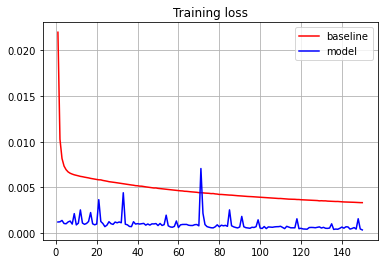

In [ ]:
import matplotlib.pyplot as plt
ep = np.linspace(1,len(Train_loss),len(Train_loss))
plt.plot(ep, Train_loss,'r', label ='baseline')
plt.plot(ep,Train_loss_m,'b', label='model')
plt.title("Training loss")
plt.legend()
plt.grid()
plt.show()

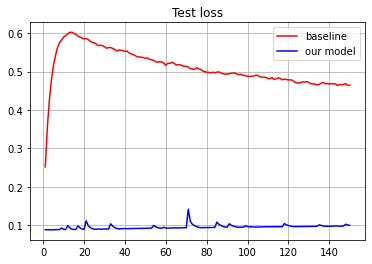

In [ ]:
plt.plot(ep, Test_loss,'r', label ='baseline')
plt.plot(ep,Test_loss_m,'b', label='our model')
plt.title("Test loss")
plt.legend()
plt.grid()
plt.show()

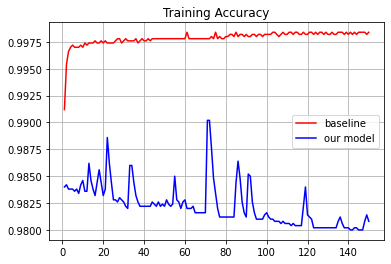

In [ ]:
plt.plot(ep, Train_acc,'r', label ='baseline')
plt.plot(ep,Train_acc_m,'b', label='our model')
plt.title("Training Accuracy")
plt.legend()
plt.grid()
plt.show()

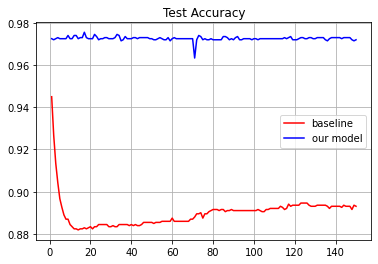

In [ ]:
plt.plot(ep, Test_acc,'r', label ='baseline')
plt.plot(ep,Test_acc_m,'b', label='our model')
plt.title("Test Accuracy")
plt.legend()
plt.grid()
plt.show()

The results from the plots can be interpreted as:<br>
LeNet is used and we can see that our model's loss is lower than baseline's loss and our model accuracy's is higher than baseline's accuracy.

The below code sample is written for testing label noise with reweighting algorithm. It is modified accordingly for MNIST, FashionMNIST and CIFAR-10 datasets.


In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
import torchvision.transforms as transforms
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
!pip install higher

In [ ]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10)).cuda()

In [ ]:
args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

In [ ]:
import copy
import random
import numpy as np

def create_noisy_dataset(original, extract_clean_per_class=100, noise_ratio=0.0):
        num_classes = len(original.classes)
        targets = np.array(original.targets)
        clean_targets = clean_data = noisy_targets = noisy_data = None
        for cls in range(num_classes):
            class_mask = targets == cls
            new_clean_targets = targets[class_mask][:extract_clean_per_class]
            new_noisy_targets = targets[class_mask][extract_clean_per_class:]
            num_noisy = int(noise_ratio * new_noisy_targets.shape[0])
            random_noise = np.random.randint(0, num_classes, num_noisy)
            other_classes = [i for i in range(num_classes) if i is not cls]
            random_noise[random_noise == cls] = random.choice(other_classes)
            new_noisy_targets[:num_noisy] = random_noise
            new_clean_data = original.data[class_mask][:extract_clean_per_class]
            new_noisy_data = original.data[class_mask][extract_clean_per_class:]
            if clean_targets is None:
                clean_targets = new_clean_targets
                clean_data = new_clean_data
                noisy_targets = new_noisy_targets
                noisy_data = new_noisy_data
            else:
                clean_targets = np.concatenate([clean_targets, new_clean_targets])
                clean_data = np.concatenate([clean_data, new_clean_data])
                noisy_targets = np.concatenate([noisy_targets, new_noisy_targets])
                noisy_data = np.concatenate([noisy_data, new_noisy_data])
        clean = copy.deepcopy(original)
        clean.data = clean_data
        clean.targets = clean_targets
        noisy = copy.deepcopy(original)
        noisy.data = noisy_data
        noisy.targets = noisy_targets
        combined = copy.deepcopy(original)
        combined.data = np.concatenate([clean_data, noisy_data])
        combined.targets = np.concatenate([clean_targets, noisy_targets])
        return clean, noisy, combined

In [ ]:
import itertools
from torch.utils.data import DataLoader

clean_data, noisy_data, combined_data = create_noisy_dataset(train_data)

combined_train_loader = DataLoader(combined_data, batch_size=128, shuffle=True, num_workers=0)
clean_loader = DataLoader(clean_data, batch_size=128, shuffle=True, num_workers=0)
clean_loader_loop = itertools.cycle(clean_loader)
train_loader = DataLoader(noisy_data, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=0)

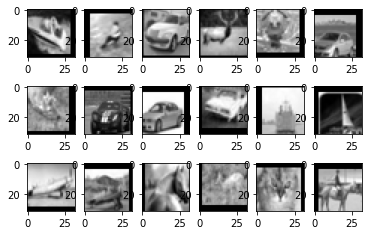

['ship', 'bird', 'car', 'deer', 'frog', 'car']
['deer', 'car', 'car', 'car', 'ship', 'ship']
['plane', 'plane', 'horse', 'deer', 'cat', 'horse']


In [ ]:
import matplotlib.pyplot as plt

for images, targets in combined_train_loader:
    for i in range(18):
        plt.subplot(3,6,i+1)
        plt.imshow(images[i][0], cmap='gray')
    plt.show() 
    
    print([classes[i.item()] for i in targets[:6]])
    print([classes[i.item()] for i in targets[6:12]])
    print([classes[i.item()] for i in targets[12:18]])
    break

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
import time
trainacc_00=[]
testacc_00=[]
model = Net().to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ep =10
for epoch in range(ep):
    start_epoch = time.time()
    correct = 0
    for images, labels in combined_train_loader:
        optimizer.zero_grad()
        predictions = model(images.cuda())
        loss = F.cross_entropy(predictions, labels.cuda())
        loss.backward()
        optimizer.step()
        correct += (torch.argmax(predictions, dim=1) == labels.cuda()).sum().item()
    #print(f"Epoch {epoch} took {time.time() - start_epoch: {3}.{4}}s")
    trainacc_00.append(100 * correct / len(train_data))
    
    with torch.no_grad():
        model.eval()
        correct = 0
        for images, labels in test_loader:
            predictions = model(images.cuda())
            correct += (torch.argmax(predictions, dim=1) == labels.cuda()).sum().item()
        testacc_00.append(100 * correct / len(test_data))
print(f"Train accuracy: {100 * correct / len(train_data): {3}.{4}}%")
print(f"Train loss: {loss.item(): {3}.{4}}")
print(f"Test accuracy: {100 * correct / len(test_data): {3}.{4}}%")
tracc00=100 * correct / len(train_data)
teacc00=100 * correct / len(test_data)

Train accuracy:  12.33%
Train loss:  1.207
Test accuracy:  61.65%


In [ ]:
import higher
trainacc_00m=[]
testacc_00m=[]
model = Net().to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    start_epoch = time.time()
    model.train()
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        with higher.innerloop_ctx(model, optimizer) as (fmodel, diffopt):
            predictions = fmodel(images.cuda())
            loss = F.cross_entropy(predictions, labels.cuda(), reduction='none')
            eps = torch.zeros_like(loss, requires_grad=True)
            eps_weighted_loss = torch.sum(loss * eps)
            diffopt.step(eps_weighted_loss)

            clean_images, clean_labels = next(clean_loader_loop)
            predictions_clean = fmodel(clean_images.cuda())
            loss_clean = F.cross_entropy(predictions_clean, clean_labels.cuda())
            grad_eps = torch.autograd.grad(loss_clean, eps)[0].detach()

        weights = torch.clamp(-grad_eps, min=0)
        weight_sum = torch.sum(weights)
        if weight_sum > 0:  # avoid zero division
            weights = weights / weight_sum

        predictions = model(images.cuda())
        loss = F.cross_entropy(predictions, labels.cuda(), reduction='none')
        loss = torch.sum(weights * loss)
        loss.backward()
        optimizer.step()

        correct += (torch.argmax(predictions, dim=1) == labels.cuda()).sum().item()
    trainacc_00m.append(100 * correct / len(noisy_data))
    #print(f"Epoch {epoch} took {time.time() - start_epoch: {3}.{4}}s")
    
    with torch.no_grad():
        model.eval()
        correct = 0
        for images, labels in test_loader:
            predictions = model(images.cuda())
            correct += (torch.argmax(predictions, dim=1) == labels.cuda()).sum().item()
        testacc_00m.append(100 * correct / len(test_data))
print(f"Train loss: {loss.item(): {3}.{4}}")
print(f"Train accuracy: {100 * correct / len(noisy_data): {3}.{4}}%")
print(f"Test accuracy: {100 * correct / len(test_data): {3}.{4}}%")
tracc00m=100 * correct / len(noisy_data)
teacc00m=100 * correct / len(test_data)

Train loss:  1.448
Train accuracy:  11.33%
Test accuracy:  55.51%


In [ ]:
trainnoiseb=[tracc00, tracc02,tracc04,tracc06,tracc08,tracc10]
trainnoisem = [tracc00m,tracc02m,tracc04m,tracc06m,tracc08m,tracc10m]
testnoiseb=[teacc00, teacc02,teacc04,teacc06,teacc08,teacc10]
testnoisem = [teacc00m,teacc02m,teacc04m,teacc06m,teacc08m,teacc10m]
n =[0,0.2,0.4,0.6,0.8,1.0]

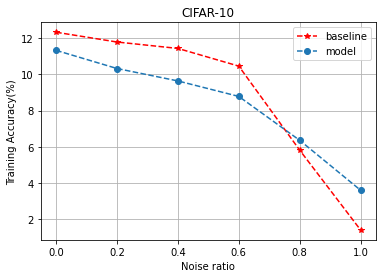

In [ ]:
import matplotlib.pyplot as plt
#ep = np.linspace(1,len(trainacc_01),len(trainacc_01))
plt.plot(n,trainnoiseb,'--*r', label ='baseline')
plt.plot(n,trainnoisem,'--o', label ='model')
plt.title("CIFAR-10")
plt.xlabel("Noise ratio")
plt.ylabel("Training Accuracy(%)")
plt.legend()
plt.grid()
plt.show()

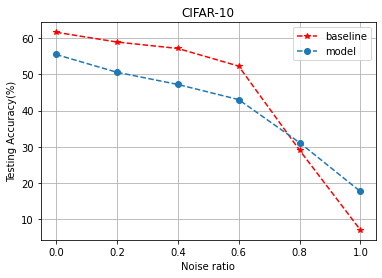

In [ ]:
import matplotlib.pyplot as plt
#ep = np.linspace(1,len(trainacc_01),len(trainacc_01))
plt.plot(n,testnoiseb,'--*r', label ='baseline')
plt.plot(n,testnoisem,'--o', label ='model')
plt.title("CIFAR-10")
plt.xlabel("Noise ratio")
plt.ylabel("Testing Accuracy(%)")
plt.legend()
plt.grid()
plt.show()